In [ ]:
# ============================================
# 1. Import Libraries
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE


In [2]:
# ============================================
# 2. Load Dataset
# ============================================
df = pd.read_csv(r"C:\Users\kanis\OneDrive\Desktop\pythonvsworksdir\amazon_music_cluster\single_genre_artists.csv")

# Check structure
print(df.shape)
df


(95837, 23)


,id_songs,name_song,popularity_songs,duration_ms,explicit,id_artists,release_date,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,name_artists,popularity_artists
0,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.563,0.1840,4,...,0.993,0.000016,0.3250,0.654,133.088,3,5078.0,['vintage chanson'],Mistinguett,22
1,1b8HZQCqcqwbzlA1jRTp6E,En Douce,0,223440,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.427,0.1800,10,...,0.989,0.000000,0.1280,0.431,78.459,3,5078.0,['vintage chanson'],Mistinguett,22
2,5d5gQxHwYovxR5pqETOIAa,J'en Ai Marre,0,208267,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.511,0.2060,0,...,0.995,0.000000,0.4180,0.481,70.443,4,5078.0,['vintage chanson'],Mistinguett,22
3,1EO65UEEPfy7CR0NK2sDxy,Ils n'ont pas ca,0,161933,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.676,0.4670,9,...,0.991,0.000000,0.2190,0.726,129.775,4,5078.0,['vintage chanson'],Mistinguett,22
4,6a58gXSgqbIsXUhVZ6ZJqe,La belote,0,167973,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.650,0.2980,9,...,0.991,0.000000,0.3730,0.844,75.950,4,5078.0,['vintage chanson'],Mistinguett,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95832,44r4zta6P9flkhKaVnbsvG,Freaks,70,174800,0,14Y3trk7LaslSFTk1G35rx,2019-02-25,0.674,0.5680,1,...,0.116,0.000000,0.1650,0.640,166.107,4,16057.0,['alt z'],Jordan Clarke,56
95833,0MmaEacabpK8Yp3Mdeo5uY,下雨天,50,265846,0,5VGgFE9nPgMfEnYiPT5J2B,2020-02-25,0.528,0.6730,4,...,0.143,0.000000,0.0989,0.297,130.066,4,929.0,['chinese viral pop'],芝麻,36
95834,1dKxf4Ht2SsKLyXfSDJAgy,The Cutest Puppy,67,82500,0,7vgGpuiXdNlCmc994PlMlz,2020-10-30,0.609,0.0172,8,...,0.996,0.973000,0.1080,0.890,68.619,4,23.0,['instrumental lullaby'],Laureen Conrad,52
95835,0SjsIzJkZfDU7wlcdklEFR,John Brown's Song,66,185250,0,4MxqhahGRT4BPz1PilXGeu,2020-03-20,0.562,0.0331,1,...,0.996,0.961000,0.1110,0.386,63.696,3,91.0,['instrumental lullaby'],Gregory Oberle,55


In [3]:
# ============================================
# 3. Data Exploration & Cleaning
# ============================================
# Info about dataset
df.info()

# Missing values
print(df.isnull().sum())

# Drop duplicates
df = df.drop_duplicates()

# Drop unnecessary columns (non-numeric)
df = df.drop(["release_date", "genres", "name_artists", "name_song", "id_artists","id_songs"], axis=1)

df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95837 entries, 0 to 95836
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_songs            95837 non-null  object 
 1   name_song           95837 non-null  object 
 2   popularity_songs    95837 non-null  int64  
 3   duration_ms         95837 non-null  int64  
 4   explicit            95837 non-null  int64  
 5   id_artists          95837 non-null  object 
 6   release_date        95837 non-null  object 
 7   danceability        95837 non-null  float64
 8   energy              95837 non-null  float64
 9   key                 95837 non-null  int64  
 10  loudness            95837 non-null  float64
 11  mode                95837 non-null  int64  
 12  speechiness         95837 non-null  float64
 13  acousticness        95837 non-null  float64
 14  instrumentalness    95837 non-null  float64
 15  liveness            95837 non-null  float64
 16  vale

,popularity_songs,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artists
count,95837.000000,9.583700e+04,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,9.583700e+04,95837.000000
mean,26.066394,2.087320e+05,0.029644,0.586853,0.541083,5.196782,-10.157862,0.648069,0.168832,0.458989,0.082145,0.224916,0.574281,117.539870,3.851362,1.979919e+05,42.819329
std,16.254133,1.177526e+05,0.169604,0.155422,0.236304,3.534923,4.748798,0.477575,0.275417,0.330416,0.232440,0.185829,0.248126,30.190399,0.544406,7.807520e+05,20.897833
min,0.000000,6.373000e+03,0.000000,0.000000,0.000020,0.000000,-50.174000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,13.000000,1.573330e+05,0.000000,0.488000,0.365000,2.000000,-12.723000,0.000000,0.034100,0.133000,0.000000,0.100000,0.378000,94.829000,4.000000,2.563000e+03,28.000000
50%,26.000000,2.040000e+05,0.000000,0.605000,0.542000,5.000000,-9.397000,1.000000,0.046200,0.453000,0.000004,0.149000,0.589000,116.595000,4.000000,1.595600e+04,40.000000
75%,37.000000,2.502670e+05,0.000000,0.700000,0.727000,8.000000,-6.692000,1.000000,0.103000,0.759000,0.001300,0.302000,0.780000,135.975000,4.000000,8.495100e+04,56.000000
max,98.000000,4.800118e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.968000,0.996000,1.000000,0.997000,1.000000,239.906000,5.000000,2.802643e+07,95.000000


In [4]:
# ============================================
# 4. Feature Scaling
# ============================================
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df.head()


,popularity_songs,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artists
0,-1.603686,-0.401735,-0.174785,-0.153476,-1.511128,-0.338561,-0.757909,0.736916,-0.427109,1.616187,-0.353338,0.538584,0.321287,0.515005,-1.563846,-0.247089,-0.996249
1,-1.603686,0.124906,-0.174785,-1.028518,-1.528056,1.358797,-1.098629,0.736916,-0.369741,1.604081,-0.353405,-0.521537,-0.577455,-1.294487,-1.563846,-0.247089,-0.996249
2,-1.603686,-0.003949,-0.174785,-0.488051,-1.418027,-1.470134,-1.127899,0.736916,-0.398062,1.622240,-0.353405,1.039046,-0.375943,-1.560003,0.273029,-0.247089,-0.996249
3,-1.603686,-0.397437,-0.174785,0.573581,-0.313510,1.075904,-0.470677,-1.357007,-0.013914,1.610134,-0.353405,-0.031836,0.611464,0.405268,0.273029,-0.247089,-0.996249
4,-1.603686,-0.346143,-0.174785,0.406294,-1.028695,1.075904,-0.768227,0.736916,-0.111948,1.610134,-0.353405,0.796887,1.087031,-1.377593,0.273029,-0.247089,-0.996249


In [5]:
# ============================================
# 5. Dimensionality Reduction (PCA for Viz)
# ============================================
from sklearn.decomposition import PCA

# Reduce to 7 components
pca = PCA(n_components=7, random_state=42)
pca_data = pca.fit_transform(scaled_data)

print("Explained Variance Ratio:", pca.explained_variance_ratio_.sum())



Explained Variance Ratio: 0.650046648492544


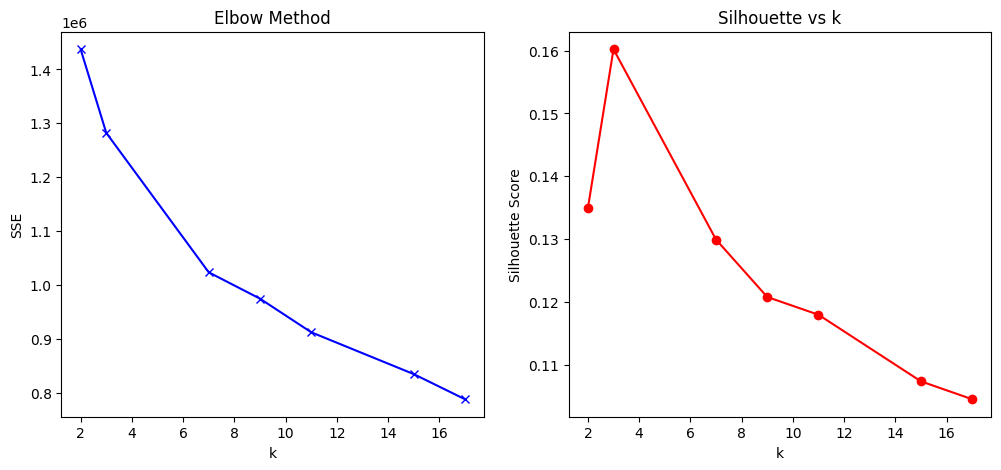

In [10]:
# ============================================
# 6. K-Means Clustering
# ============================================
# Elbow Method
sse = []
sil_scores = []
K = (2,3,7,9,11,15,17)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init="auto", max_iter=200)
    labels = kmeans.fit_predict(scaled_data)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_data, labels))

# Plot SSE (Elbow)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')

# Plot Silhouette Score
plt.subplot(1,2,2)
plt.plot(K, sil_scores, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette vs k')
plt.show()


In [11]:
# Fit with chosen k (example k=5)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster_KMeans'] = kmeans.fit_predict(scaled_data)

# Evaluation
print("Silhouette Score:", silhouette_score(scaled_data, df['Cluster_KMeans']))
print("Davies-Bouldin Index:", davies_bouldin_score(scaled_data, df['Cluster_KMeans']))


Silhouette Score: 0.16021618314909075
Davies-Bouldin Index: 2.0314301701854927


In [ ]:
# ============================================
# 7. DBSCAN
# ============================================
from sklearn.cluster import DBSCAN

for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_samples in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(pca_data)   # use PCA reduced data
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(pca_data, labels)
            print(f"eps={eps}, min_samples={min_samples}, clusters={n_clusters}, silhouette={score:.3f}")



Silhouette Score (DBSCAN): -0.1457671524600061


✅ Hierarchical clustering completed on 2000 samples


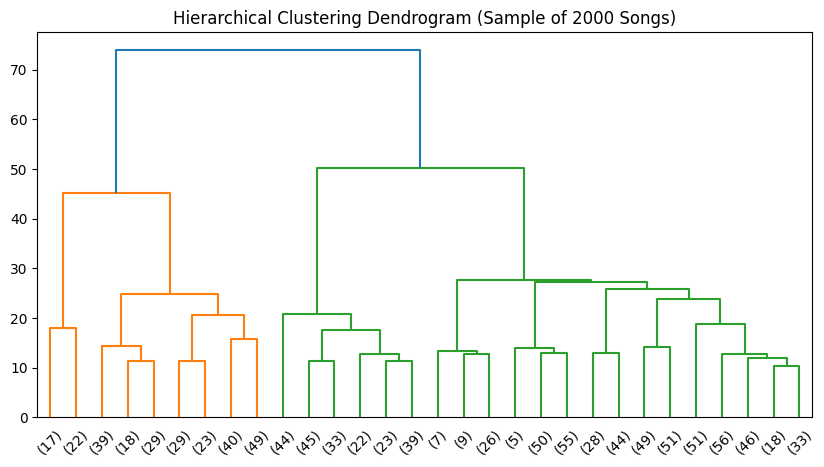

In [14]:
# ============================================
# 8. Hierarchical Clustering (Sampled)
# ============================================

# Take only a sample for hierarchical (avoid memory error)
pca = PCA(n_components=10, random_state=42)
pca_data = pca.fit_transform(scaled_data)

# Take only 2000 samples for hierarchical (avoid MemoryError)
sample_size = 2000
sample_pca = pca_data[:sample_size]

agg = AgglomerativeClustering(n_clusters=5, linkage="ward")
sample_labels = agg.fit_predict(sample_pca)

df_sample = df.iloc[:sample_size].copy()
df_sample['Cluster_Hierarchical'] = sample_labels

print("✅ Hierarchical clustering completed on 2000 samples")

# Dendrogram on sample

linked = linkage(sample_df, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30)  # show last 30 merges
plt.title("Hierarchical Clustering Dendrogram (Sample of 2000 Songs)")
plt.show()






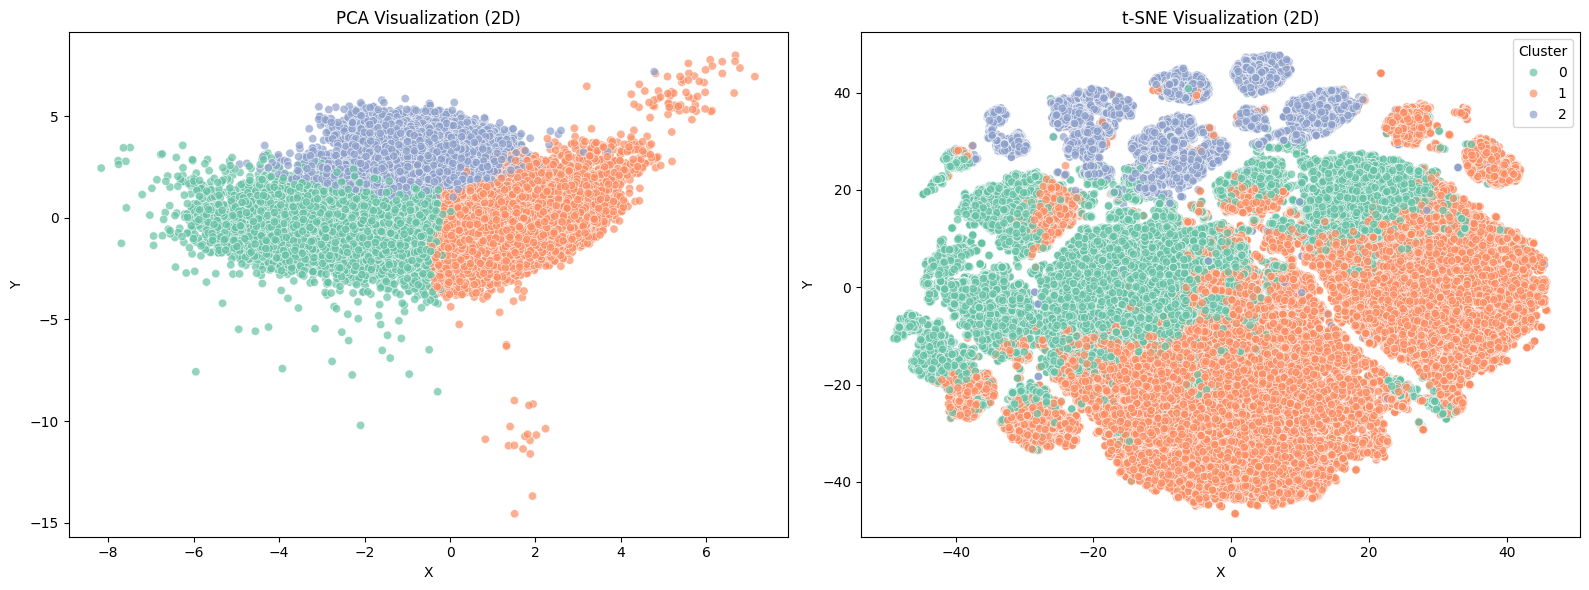

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ============================================
# Step 1: PCA for speed (reduce to 50D first)
# ============================================
pca_50 = PCA(n_components=15, random_state=42).fit_transform(scaled_data)

# ============================================
# Step 2: PCA (2D)
# ============================================
pca_2d = PCA(n_components=2, random_state=42).fit_transform(scaled_data)

# ============================================
# Step 3: t-SNE (2D)
# ============================================
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_2d = tsne.fit_transform(pca_50)

# ============================================
# Step 4: Create DataFrames
# ============================================
pca_df = pd.DataFrame(pca_2d, columns=['X', 'Y'])
pca_df['Cluster'] = df['Cluster_KMeans']

tsne_df = pd.DataFrame(tsne_2d, columns=['X', 'Y'])
tsne_df['Cluster'] = df['Cluster_KMeans']

# ============================================
# Step 5: Side-by-Side Plots
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# PCA Plot
sns.scatterplot(ax=axes[0], x='X', y='Y', hue='Cluster', 
                palette='Set2', data=pca_df, alpha=0.7, legend=False)
axes[0].set_title("PCA Visualization (2D)")

# t-SNE Plot
sns.scatterplot(ax=axes[1], x='X', y='Y', hue='Cluster', 
                palette='Set2', data=tsne_df, alpha=0.7, legend='full')
axes[1].set_title("t-SNE Visualization (2D)")

plt.tight_layout()
plt.show()


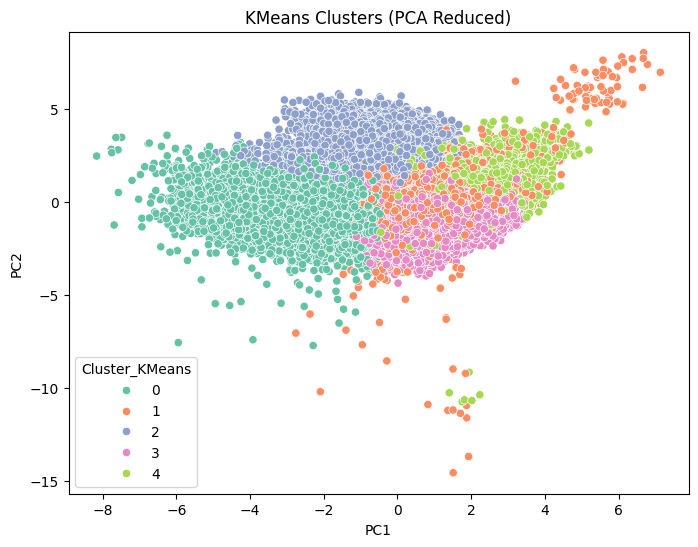

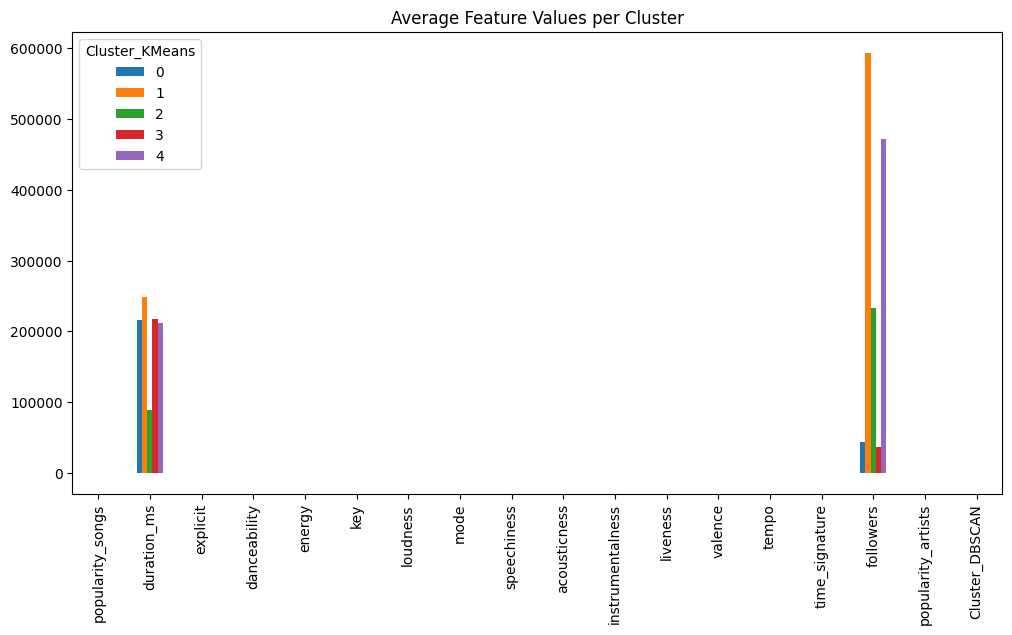

In [15]:
# ============================================
# 9. Visualization
# ============================================
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=df['Cluster_KMeans'], palette="Set2")
plt.title("KMeans Clusters (PCA Reduced)")
plt.show()

# Cluster profiles
cluster_profile = df.groupby('Cluster_KMeans').mean()
cluster_profile.T.plot(kind='bar', figsize=(12,6))
plt.title("Average Feature Values per Cluster")
plt.show()


In [ ]:
# ============================================
# 10. Save Results
# ============================================
df.to_csv("clustered_music_dataset.csv", index=False)
print("✅ Final dataset with clusters saved!")
